## TO DO:
* do some hyper-parameter tuning (bs 32 better than bs 8)
* train until early stopping 
* 

In [7]:
import os
from pathlib import Path
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    top_k_accuracy_score
)


In [8]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

Using device: mps


In [ ]:
project_root   = Path().resolve()
medium_ds_root  = project_root / "medium_dataset"
batch_size     = 32

In [14]:
# List of country folders (labels)
COUNTRIES = sorted([d.name for d in medium_ds_root.iterdir() if d.is_dir()])
num_classes = len(COUNTRIES)

### Data

In [15]:
class CountryImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform
        for idx, country in enumerate(COUNTRIES):
            country_dir = root_dir / country
            for img_file in country_dir.iterdir():
                if img_file.suffix.lower() in (".jpg", ".jpeg", ".png"):
                    self.samples.append((img_file, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, i):
        path, label = self.samples[i]
        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

In [16]:
# Transforms: resize + normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

In [31]:
dataset = CountryImageDataset(medium_ds_root, transform=transform)
labels = [label for _, label in dataset.samples]  
# samples holds (path,label) pairs in order

# 2) Stratified split indices (80% train, 20% test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(sss.split(X=[0]*len(labels), y=labels))

# 3) Create PyTorch subset datasets
train_ds = Subset(dataset, train_idx)
test_ds  = Subset(dataset, test_idx)

# 4) Loaders (with num_workers=0)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

### Model

In [18]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


In [19]:
for param in model.parameters():
    param.data = param.data.to(device)
for buf in model.buffers():
    buf.data = buf.data.to(device)

### Training 

In [20]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 1e-4)

In [21]:
def compute_accuracy(outputs, labels):
    preds = outputs.argmax(dim=1)
    return (preds==labels).sum().item() / labels.size(0)

In [33]:
epochs = 20
patience, eval_every = 3, 50   # early stopping patience in eval steps
checkpoint_path = f"medium_models/resnet_finetuned_{batch_size}.pth"

In [32]:
len(train_loader)

2946

In [34]:
best_val_loss, patience_counter = float('inf'), 0
train_losses, train_accs = [], []
val_losses, val_accs     = [], []

batch = 1
try:
    for epoch in range(1, epochs+1):
        model.train()
        for imgs, lbls in train_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            optimizer.zero_grad()
            outs = model(imgs)
            loss = criterion(outs, lbls)
            loss.backward(); optimizer.step()

            # Log per batch
            acc = compute_accuracy(outs, lbls)
            train_losses.append(loss.item()); train_accs.append(acc)
            if batch % eval_every == 0:
                # evaluate on test set
                model.eval()
                vl, va, count = 0.0, 0.0, 0
                with torch.no_grad():
                    for t_imgs, t_lbls in test_loader:
                        t_imgs, t_lbls = t_imgs.to(device), t_lbls.to(device)
                        t_outs = model(t_imgs)
                        vl += criterion(t_outs, t_lbls).item() * t_imgs.size(0)
                        va += compute_accuracy(t_outs, t_lbls) * t_imgs.size(0)
                        count += t_imgs.size(0)
                vl /= count; va /= count
                val_losses.append(vl); val_accs.append(va)
                print(f"[Epoch {epoch}/{epochs}, Batch {batch}/2946] "
                      f"Train Loss={loss:.4f}, Train Acc={acc:.4f} | "
                      f"Val Loss={vl:.4f}, Val Acc={va:.4f}")

                # Early stopping check
                if vl < best_val_loss:
                    best_val_loss = vl; patience_counter = 0
                    torch.save(model.state_dict(), checkpoint_path)
                    print("  ↳ Checkpoint saved.")
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping triggered.")
                        raise KeyboardInterrupt
                model.train()
            batch += 1

        # End of epoch evaluation
        model.eval()
        vl, va, count = 0.0, 0.0, 0
        with torch.no_grad():
            for t_imgs, t_lbls in test_loader:
                t_imgs, t_lbls = t_imgs.to(device), t_lbls.to(device)
                t_outs = model(t_imgs)
                vl += criterion(t_outs, t_lbls).item() * t_imgs.size(0)
                va += compute_accuracy(t_outs, t_lbls) * t_imgs.size(0)
                count += t_imgs.size(0)
        vl /= count; va /= count
        
        print(f"[Epoch {epoch}/{epochs}] Train Loss={loss:.4f}, Train Acc={acc:.4f} | "
              f"Val Loss={vl:.4f}, Val Acc={va:.4f}")

except KeyboardInterrupt:
    print("\nInterrupted! Saving latest model…")
    torch.save(model.state_dict(), checkpoint_path)

print("Training complete.")

[Epoch 1/20, Batch 50/2946] Train Loss=2.1407, Train Acc=0.2500 | Val Loss=2.2016, Val Acc=0.3975
  ↳ Checkpoint saved.
[Epoch 1/20, Batch 100/2946] Train Loss=1.5435, Train Acc=0.5000 | Val Loss=2.1915, Val Acc=0.4041
  ↳ Checkpoint saved.
[Epoch 1/20, Batch 150/2946] Train Loss=3.2775, Train Acc=0.0000 | Val Loss=2.1215, Val Acc=0.4134
  ↳ Checkpoint saved.

Interrupted! Saving latest model…
Training complete.


MIC laptop:
bs32 - 20 minutes for one epoch
bs8 - 83 mintues for one epoch 

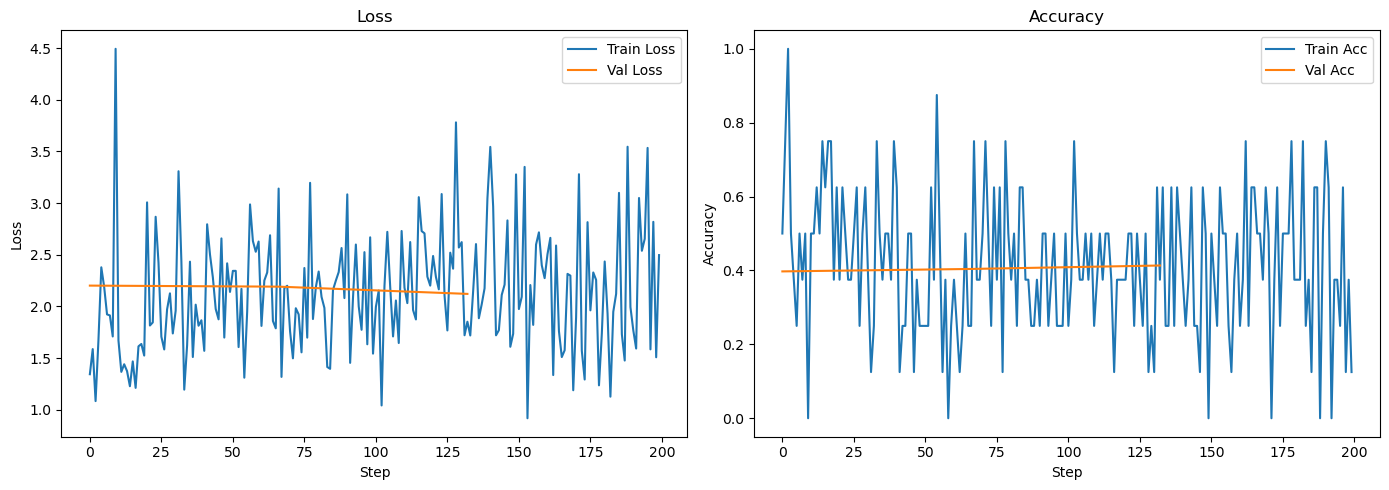

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Losses
axs[0].plot(train_losses, label='Train Loss')
axs[0].plot(np.arange(0, len(train_losses)-len(val_losses), len(train_losses)//len(val_losses)), val_losses, label='Val Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot Accuracies
axs[1].plot(train_accs, label='Train Acc')
axs[1].plot(np.arange(0, len(train_accs)-len(val_losses), len(train_accs)//len(val_accs)), val_accs, label='Val Acc')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Step')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()

### Evaluation

In [37]:
model.to(device)
model.eval()

# Containers
all_preds      = []
all_targets    = []
all_probs      = []
test_loss, test_correct, total_samples = 0.0, 0, 0

softmax = torch.nn.Softmax(dim=1)

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss    = criterion(outputs, labels)

        # accumulate loss & top‐1 accuracy
        test_loss    += loss.item() * imgs.size(0)
        preds         = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

        # store for detailed metrics
        probs   = softmax(outputs).cpu().numpy()
        all_probs.append(probs)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

# flatten lists
all_probs   = np.vstack(all_probs)       # shape (N, num_classes)
all_preds   = np.concatenate(all_preds)   # shape (N,)
all_targets = np.concatenate(all_targets) # shape (N,)

In [38]:
# 1) Overall Test Loss & Top-1 Accuracy
test_loss /= total_samples
test_acc   = test_correct / total_samples
print(f"Test Loss: {test_loss:.4f}, Top-1 Accuracy: {test_acc:.4f}")


# 2) Top-K Accuracy (K=3,5)
top3_acc = top_k_accuracy_score(all_targets, all_probs, k=3)
top5_acc = top_k_accuracy_score(all_targets, all_probs, k=5)
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")

Test Loss: 2.1674, Top-1 Accuracy: 0.4129
Top-3 Accuracy: 0.6164
Top-5 Accuracy: 0.7155


In [39]:
# 3) Classification Report
report = classification_report(
    all_targets, all_preds, target_names=COUNTRIES, zero_division=0
)
print("\nClassification Report:\n")
print(report)


Classification Report:

                precision    recall  f1-score   support

       Albania       0.51      0.72      0.60       100
     Argentina       0.26      0.36      0.30       100
     Australia       0.38      0.34      0.36       100
       Austria       0.38      0.08      0.13        76
       Belgium       0.28      0.15      0.19        81
       Bolivia       0.48      0.57      0.52       100
      Botswana       0.60      0.51      0.55       100
        Brazil       0.31      0.19      0.24       100
      Bulgaria       0.38      0.21      0.27        94
      Cambodia       0.34      0.25      0.29        80
        Canada       0.24      0.38      0.30       100
         Chile       0.29      0.38      0.33       100
      Colombia       0.38      0.03      0.06       100
       Czechia       0.11      0.01      0.02        88
       Denmark       0.26      0.11      0.16        80
       Ecuador       0.74      0.40      0.52       100
       Finland       0

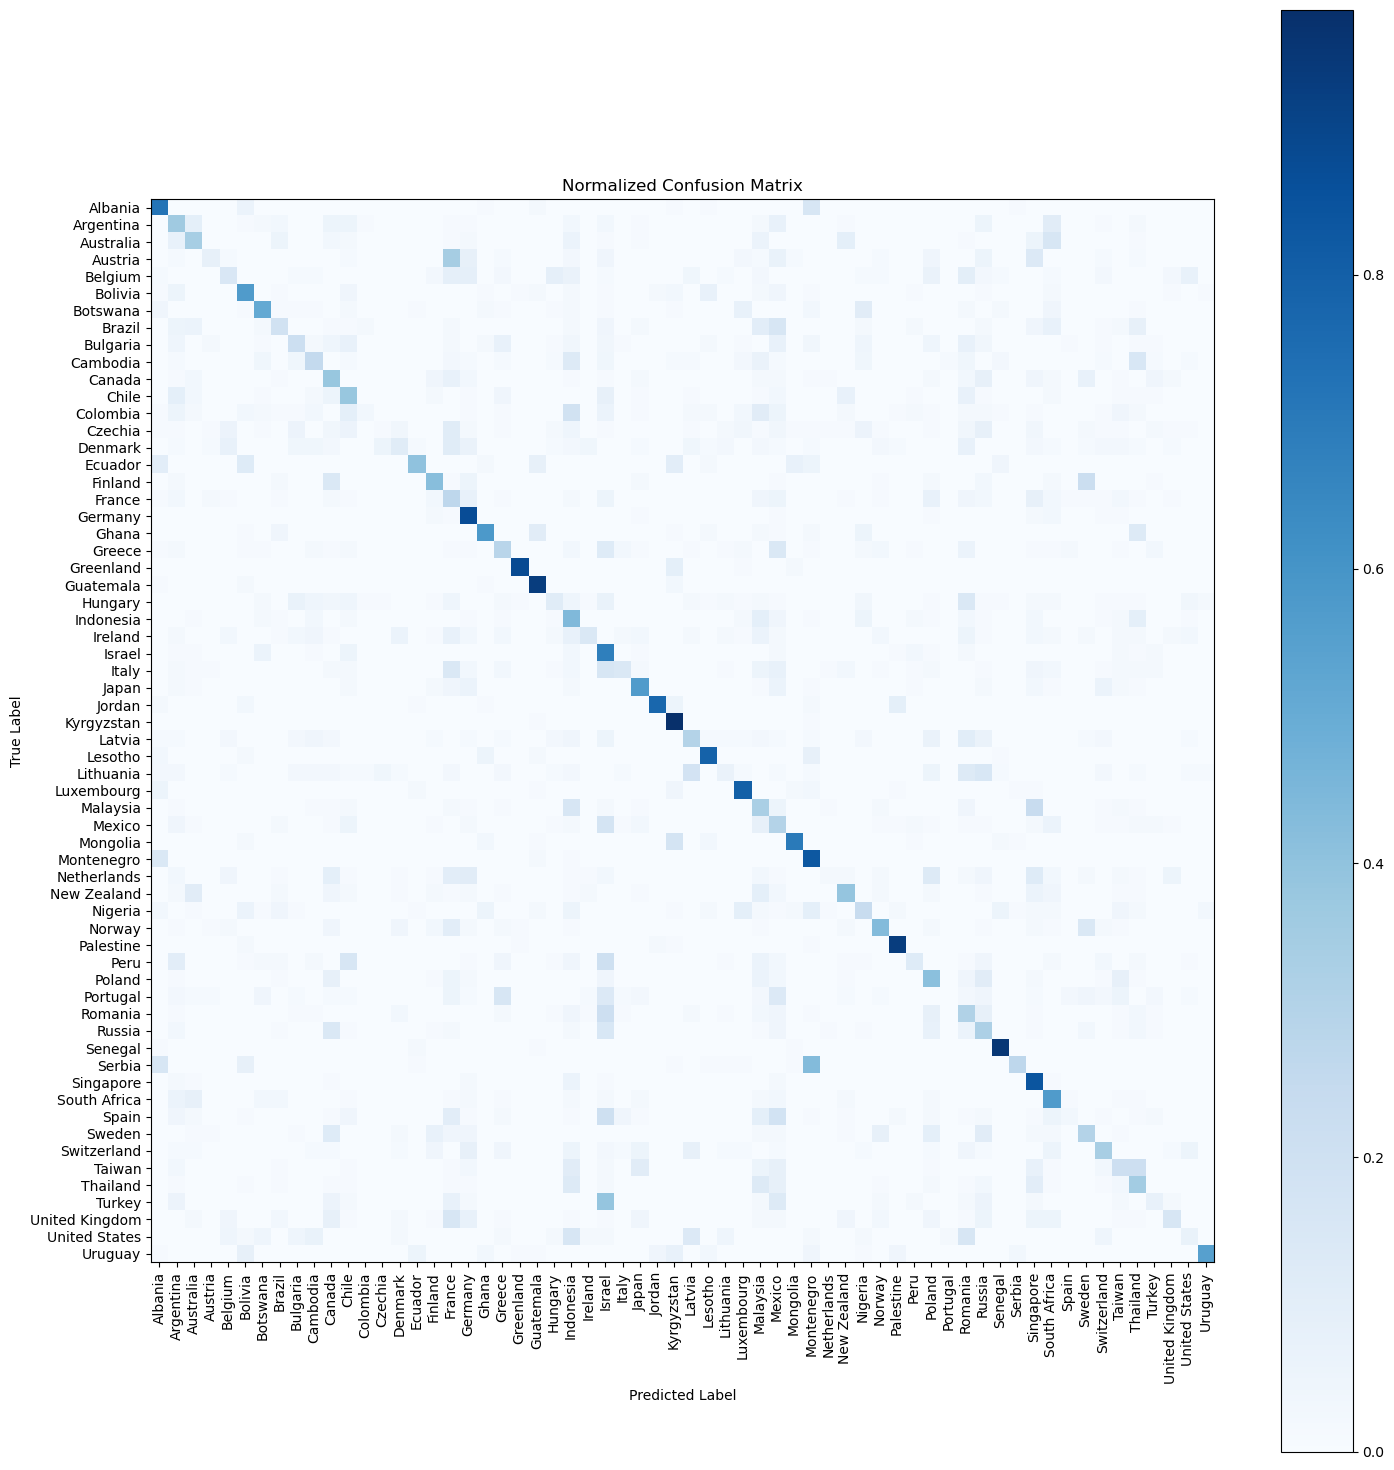

In [40]:
# 4) Confusion Matrix (normalized)
cm = confusion_matrix(all_targets, all_preds, normalize='true')
fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.set_title("Normalized Confusion Matrix")
fig.colorbar(im, ax=ax)
tick_marks = np.arange(len(COUNTRIES))
ax.set_xticks(tick_marks); ax.set_yticks(tick_marks)
ax.set_xticklabels(COUNTRIES, rotation=90); ax.set_yticklabels(COUNTRIES)
ax.set_ylabel('True Label'); ax.set_xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [41]:
# 5) Sample Predictions with Probabilities
print("\nSample predictions with top-3 probabilities:\n")
for i in np.random.choice(total_samples, size=5, replace=False):
    true_lbl = COUNTRIES[all_targets[i]]
    probs_i  = all_probs[i]
    topk_idx = probs_i.argsort()[::-1][:3]
    topk_labels = [f"{COUNTRIES[idx]} ({probs_i[idx]:.2f})" for idx in topk_idx]
    print(f"True: {true_lbl:20s}  ↔  Predicted Top-3: {', '.join(topk_labels)}")


Sample predictions with top-3 probabilities:

True: South Africa          ↔  Predicted Top-3: South Africa (0.91), Argentina (0.03), Mexico (0.01)
True: Hungary               ↔  Predicted Top-3: United States (0.26), Indonesia (0.19), Australia (0.09)
True: Norway                ↔  Predicted Top-3: Norway (0.97), Sweden (0.02), Portugal (0.00)
True: Kyrgyzstan            ↔  Predicted Top-3: Kyrgyzstan (1.00), Guatemala (0.00), Mongolia (0.00)
True: Sweden                ↔  Predicted Top-3: Canada (0.19), Sweden (0.13), Norway (0.10)
